In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh 

Los datos del problema son:

In [2]:
densidad= 7850 #
A=10E-4
L_total =1
I=10E-8
E= 210e9
n_elementos=3
gl=2

La siguiente funcion primero calcula las matriz de nodos, la matriz de conectividad y los vectores s y r.
Luego calcula las matrices locales de rigidez, concentrada y consistente y finalmente las ensambla en sus respectivas matrices globales.

In [3]:
def oscilaciones(n_elementos, L_total, I, E, A, densidad,gl):

    n_nodos=n_elementos+1
    MN=np.linspace(0,L_total,n_elementos+1).reshape(-1,1)
    MN=np.hstack([MN, np.zeros_like(MN)])
    MC = ([[0,1]])
    for i in range(n_elementos-1):
        MC.append([MC[-1][1],MC[-1][1] +1])
    MC = np.array(MC)

    K = np.zeros((2*n_nodos,2*n_nodos))
    consistente_global = np.zeros((2*n_nodos,2*n_nodos))
    concentrada_global = np.zeros((2*n_nodos,2*n_nodos))
    L=L_total/n_elementos
    s=[0,1]
    r=(np.linspace(2,2*n_nodos-1,2*n_nodos-2)).astype(int)

    for e in range (len(MC)):
        a, b= MC[i] 
        a=int(a)
        b=int(b)
        x1, y1 = MN[a]
        x2, y2 = MN[b]


        K_local =  ((E*I)/L**3) * np.array(
                [(12,6*L,-12,6*L),
                 (6*L,4*L**2,-6*L,2*L**2),
                 (-12,-6*L,12,-6*L),
                 (6*L,2*L**2, -6*L,4*L**2)])

        for i in MC[e]:
            columna_i = list(MC[e]).index(i) # identifico en que columna de MC esta el elemento i
            index_i = np.linspace(i*gl,(i+1)*gl-1,gl).astype(int)
            ind_col_i = np.linspace(columna_i*gl,(columna_i+1)*gl-1,gl).astype(int)
            for j in MC[e]:
                columna_j = list(MC[e]).index(j) # # identifico en que columna de MC esta el elemento i
                index_j = np.linspace(j*gl,(j+1)*gl-1,gl).astype(int)
                ind_col_j = np.linspace(columna_j*gl,(columna_j+1)*gl-1,gl).astype(int)
                K[np.ix_(index_i, index_j)] +=  K_local[np.ix_(ind_col_i , ind_col_j)]

        concentrada_local = densidad*A*(L/24) * np.array(
                    [(12,0,0,0),
                     (0,L**2,0,0),
                     (0,0,12,0),
                     (0,0,0,L**2)])


        for i in MC[e]:
            columna_i = list(MC[e]).index(i) # identifico en que columna de MC esta el elemento i
            index_i = np.linspace(i*gl,(i+1)*gl-1,gl).astype(int)
            ind_col_i = np.linspace(columna_i*gl,(columna_i+1)*gl-1,gl).astype(int)
            for j in MC[e]:
                columna_j = list(MC[e]).index(j) # # identifico en que columna de MC esta el elemento i
                index_j = np.linspace(j*gl,(j+1)*gl-1,gl).astype(int)
                ind_col_j = np.linspace(columna_j*gl,(columna_j+1)*gl-1,gl).astype(int)
                concentrada_global[np.ix_(index_i, index_j)] +=  concentrada_local[np.ix_(ind_col_i , ind_col_j)]

                
        consistente_local = (densidad*A*L/420) * np.array(
                                                        [[156, 22*L, 54, -13*L],
                                                         [22*L, 4*L**2, 13*L, -3*L**2],
                                                         [54, 13*L, 156, -22*L],
                                                         [-13*L, -3*L**2, -22*L, 4*L**2]])
        for i in MC[e]:
            columna_i = list(MC[e]).index(i) # identifico en que columna de MC esta el elemento i
            index_i = np.linspace(i*gl,(i+1)*gl-1,gl).astype(int)
            ind_col_i = np.linspace(columna_i*gl,(columna_i+1)*gl-1,gl).astype(int)
            for j in MC[e]:
                columna_j = list(MC[e]).index(j) # # identifico en que columna de MC esta el elemento i
                index_j = np.linspace(j*gl,(j+1)*gl-1,gl).astype(int)
                ind_col_j = np.linspace(columna_j*gl,(columna_j+1)*gl-1,gl).astype(int)
                consistente_global[np.ix_(index_i, index_j)] +=  consistente_local[np.ix_(ind_col_i , ind_col_j)]

    return(K, consistente_global, concentrada_global,r,MN)

Ahora se resuelve el problema de autovectores/autovalores:

In [4]:
K,consistente_global,concentrada_global,r,MN = oscilaciones(n_elementos, L_total, I, E, A, densidad,gl)

w_concentrada, vl_r_concentrada = eigh(K[np.ix_(r,r)], concentrada_global[np.ix_(r,r)])
w_consistente, vl_r_consistente = eigh(K[np.ix_(r,r)], consistente_global[np.ix_(r,r)])



Se agregan dos grados de libertad por el nodo empotrado en el extremo.
Tambien se calculan las frecuencias y se normalizan los autovectores (para que en el borde libre, el maximo desplazamiento sea 1). 

In [5]:
n_nodos=n_elementos+1
vl_concentrada=np.vstack([np.zeros((2,2*(n_nodos-1))),vl_r_concentrada])
vl_consistente=np.vstack([np.zeros((2,2*(n_nodos-1))),vl_r_consistente])

frecuencia_concentrada = np.sqrt(w_concentrada)/(2*np.pi)
frecuencia_consistente = np.sqrt(w_consistente)/(2*np.pi)

vl_normalizado_concentrada=vl_concentrada/vl_concentrada[-2,:]
vl_normalizado_consistente=vl_consistente/vl_consistente[-2,:]



Los desplazamientos son las posiciones impares de cada fila (las posiciones pares son angulos).

In [6]:
matriz_desplazamientos = vl_normalizado_consistente[::2]

Graficando desplazamientos en funcion de posicion, para los primeros 3 modos normales: 

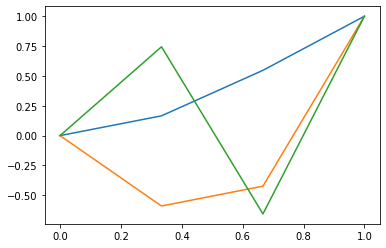

In [7]:
posicion = MN[:,0]

for i in range(3):
    desplazamientos = matriz_desplazamientos[:,i]
    plt.plot(posicion,desplazamientos)

Ahora grafico utilizando la funcion interpolacion, usando la matriz concentrada: 

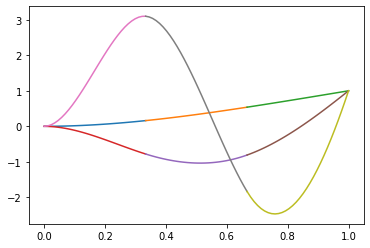

In [8]:
v = lambda a1, a2, a3, a4, x: a1*x**3 + a2*x**2 + a3*x + a4

L = L_total/n_elementos

for i in range(3):
    autovector = vl_normalizado_concentrada[:,i]
    for j in range(n_elementos):
        d1 = autovector[2*j]
        fi1 = autovector[(2*j)+1]
        d2 = autovector[2* (j+1)]
        fi2 = autovector[2*(j+1) +1]
        a1 = (2*(d1-d2))/(L**3)  + (fi1+fi2)/L**2 
        a2 = (-3*(d1-d2))/(L**2)  - (2*fi1 + fi2)/L
        a3 = fi1 
        a4 = d1 
        X = np.linspace(MN[j,0],MN[j+1,0],30)
        Y = v(a1,a2,a3,a4,np.linspace(0,L,30))
        plt.plot(X,Y)


Y la funcion interpolacion con la matriz consistente queda:

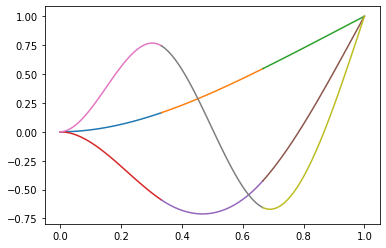

In [9]:
v = lambda a1, a2, a3, a4, x: a1*x**3 + a2*x**2 + a3*x + a4

L = L_total/n_elementos

for i in range(3):
    autovector = vl_normalizado_consistente[:,i]
    for j in range(n_elementos):
        d1 = autovector[2*j]
        fi1 = autovector[(2*j)+1]
        d2 = autovector[2* (j+1)]
        fi2 = autovector[2*(j+1) +1]
        a1 = (2*(d1-d2))/(L**3)  + (fi1+fi2)/L**2 
        a2 = (-3*(d1-d2))/(L**2)  - (2*fi1 + fi2)/L
        a3 = fi1 
        a4 = d1 
        X = np.linspace(MN[j,0],MN[j+1,0],30)
        Y = v(a1,a2,a3,a4,np.linspace(0,L,30))
        plt.plot(X,Y)

Finalmente se estudia la convergencia para matriz concentrada y la matriz consistente: 

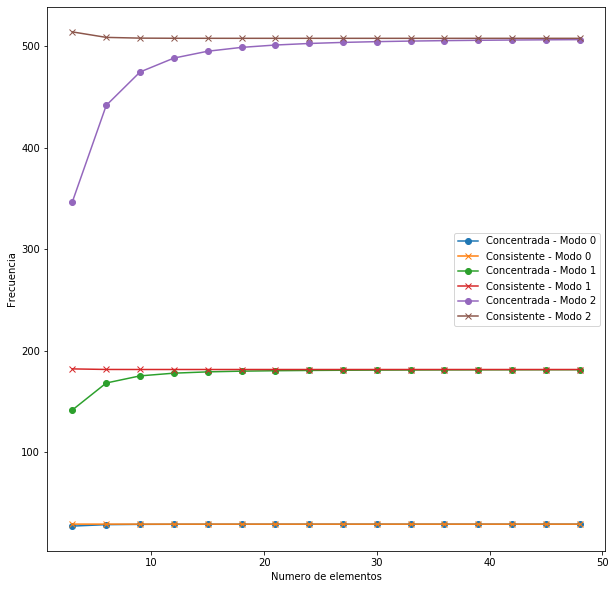

In [10]:
n_elementos = 50
lista_consistente = []
lista_concentrada = []

for elementos in range(3, n_elementos, 3):
    K,consistente_global,concentrada_global,r,MN = oscilaciones(elementos, L_total, I, E, A, densidad,gl)
    w_concentrada, vl_r_concentrada = eigh(K[np.ix_(r,r)], concentrada_global[np.ix_(r,r)])
    w_consistente, vl_r_consistente = eigh(K[np.ix_(r,r)], consistente_global[np.ix_(r,r)])

    frecuencia_concentrada = np.sqrt(w_concentrada)/(2*np.pi)
    frecuencia_consistente = np.sqrt(w_consistente)/(2*np.pi)
    
    lista_concentrada.append(frecuencia_concentrada[0:3])
    lista_consistente.append(frecuencia_consistente[0:3])

    
    
X = np.arange(3,n_elementos,3)

plt.figure(figsize=(10, 10))
for i in range(3):
    plt.plot(X, np.array(lista_concentrada)[:,i],'o-' , label = 'Concentrada - Modo ' + str(i))
    plt.plot(X, np.array(lista_consistente)[:,i],'x-', label = 'Consistente - Modo ' + str(i))

plt.legend()
plt.xlabel("Numero de elementos")
plt.ylabel("Frecuencia")
plt.show()

Se puede ver que para el primer modo normal la convergencia es inmediata, pero para modos mayores se necesitan cada vez mas elementos para que convergan. 